# Librerias

In [37]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt #gráficos
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import random
import os

In [38]:
import warnings
warnings.filterwarnings('ignore')

In [39]:
if torch.cuda.is_available():
    print("Utilizamos la primera GPU disponible")
    DEVICE=device = torch.device('cuda:0')
    os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
else:
    print("No hay GPU, toca correr todo en CPU")
    DEVICE=device = torch.device('cpu')

DEVICE

Utilizamos la primera GPU disponible


device(type='cuda', index=0)

In [40]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1" if torch.cuda.is_available() else "0"

In [41]:
def reset_seed():
    SEED = 42
    torch.backends.cudnn.enabled = True
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
        torch.cuda.manual_seed_all(SEED)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [42]:
reset_seed()

# Carga de datos

In [43]:
df = pd.read_parquet('../../Datos/df_train.parquet')
print(df.shape)
df.head(5)

(3680, 20)


,id,id_bar,anio,semana,ESTRATO,area_barrio,dengue,concentraciones,vivienda,equipesado,sumideros,maquina,lluvia_mean,lluvia_var,lluvia_max,lluvia_min,temperatura_mean,temperatura_var,temperatura_max,temperatura_min
0,4_2015_01,4,2015,1,3.0,0.560,0.0,0.0,0.0,0.0,0.0,0.0,0.000651,0.000041,0.0625,0.0,26.163889,11.588928,31.8,20.9
1,5_2015_01,5,2015,1,3.0,0.842,0.0,0.0,0.0,0.0,0.0,0.0,0.000651,0.000041,0.0625,0.0,26.163889,11.588928,31.8,20.9
2,3_2015_01,3,2015,1,1.0,0.781,0.0,0.0,0.0,0.0,0.0,0.0,0.000651,0.000041,0.0625,0.0,26.163889,11.588928,31.8,20.9
3,8_2015_01,8,2015,1,2.0,0.394,0.0,0.0,0.0,0.0,0.0,0.0,0.000651,0.000041,0.0625,0.0,26.163889,11.588928,31.8,20.9
4,9_2015_01,9,2015,1,2.0,0.292,0.0,0.0,0.0,0.0,0.0,0.0,0.000651,0.000041,0.0625,0.0,26.163889,11.588928,31.8,20.9


In [44]:
# Establecemos una variable que se llame fecha, donde solo te tienen en cuenta el año y el mes

df['fecha'] = df['anio'].astype(str) + df['semana'].astype(str).str.zfill(2)
df = df.sort_values(by=['fecha','id_bar'])

# Breve entendimiento

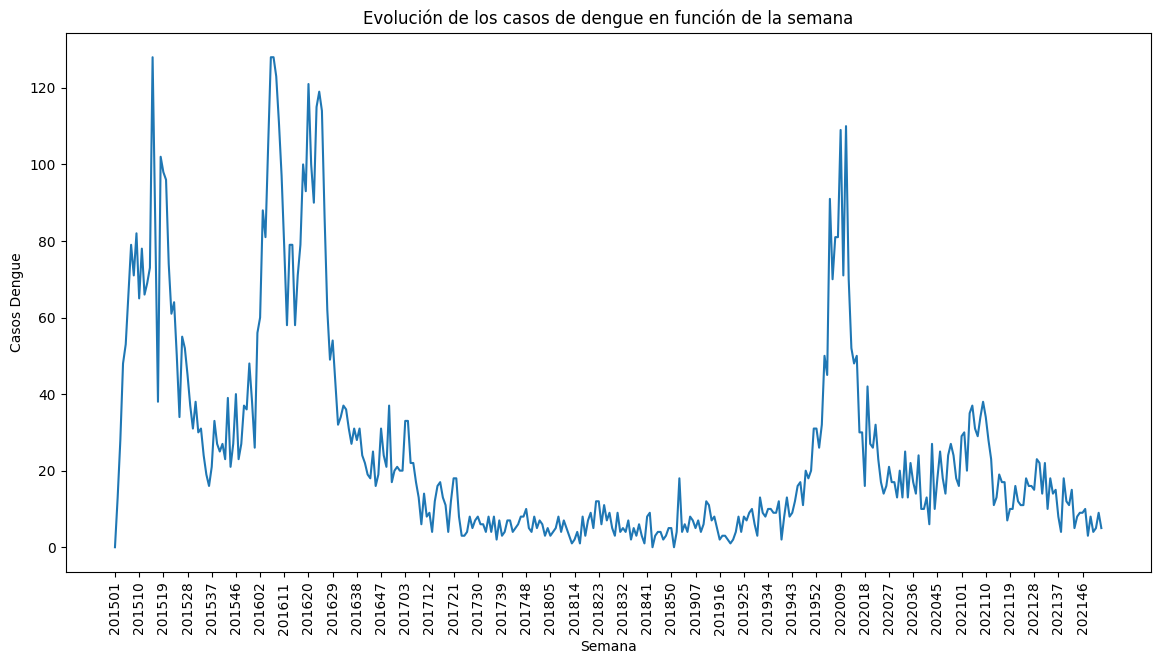

In [45]:
# Group by year and week, summing 'Casos_Dengue'
dengue_by_week = df.groupby(['fecha'])['dengue'].sum().reset_index()

# Rename columns for clarity
dengue_by_week.columns = ['fecha', 'dengue']

plt.figure(figsize=(14,7))
ax = plt.gca() # get current axis
plt.plot(dengue_by_week.fecha, dengue_by_week.dengue)
plt.xlabel('Semana')
plt.ylabel('Casos Dengue')
plt.title('Evolución de los casos de dengue en función de la semana')
plt.xticks(np.arange(0,368,9), rotation=90)
plt.show()

<Figure size 1400x700 with 0 Axes>

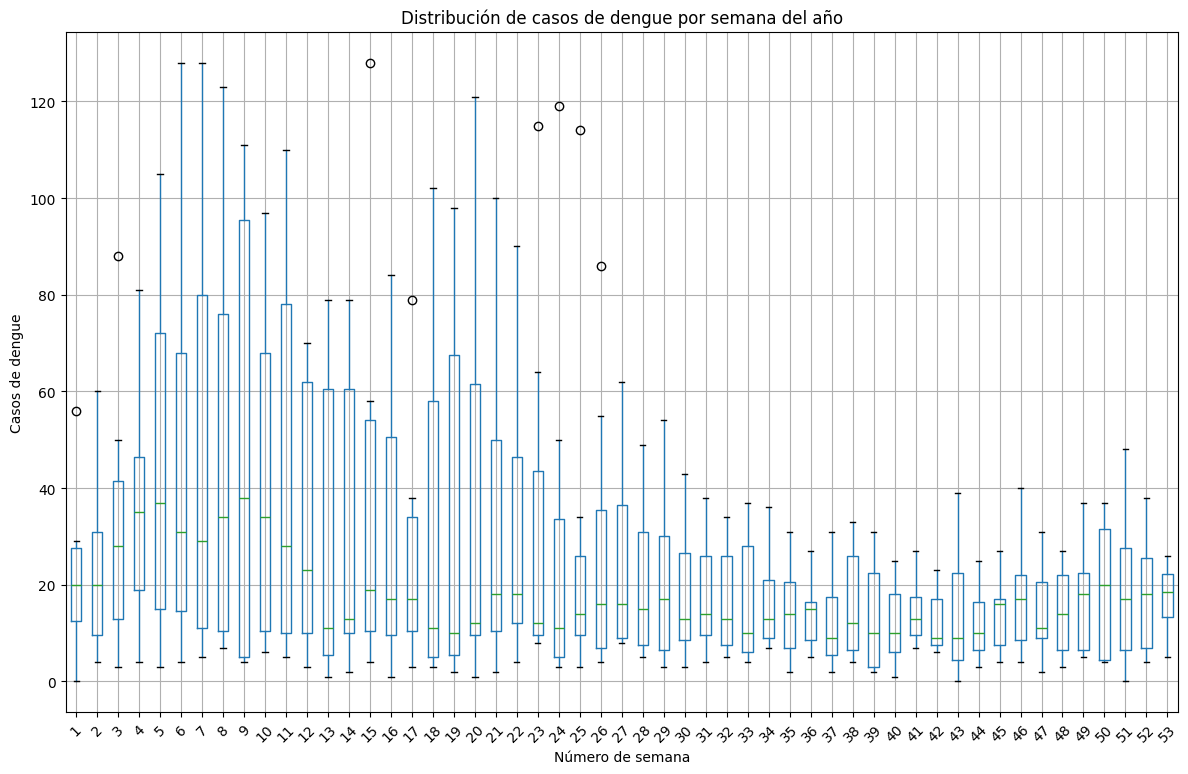

In [46]:
# Extract week number from the 'fecha' column
dengue_by_week['week'] = dengue_by_week['fecha'].str[4:].astype(int)

# Group by week number and create boxplots
plt.figure(figsize=(14, 7))
dengue_by_week.boxplot(column='dengue', by='week', figsize=(12, 8))
plt.title('Distribución de casos de dengue por semana del año')
plt.xlabel('Número de semana')
plt.ylabel('Casos de dengue')
plt.suptitle('') # Remove the default boxplot title
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


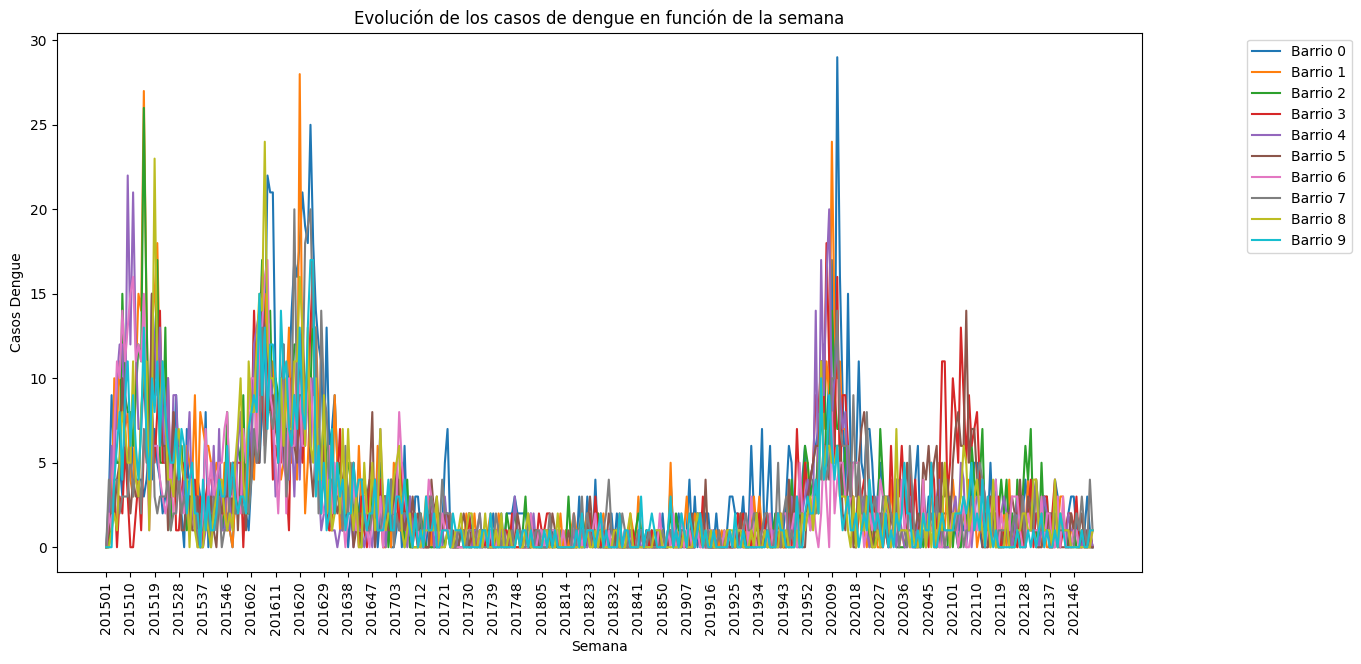

In [47]:
plt.figure(figsize=(14,7))
ax = plt.gca()  # Obtener el eje actual

# Graficar cada barrio en el mismo gráfico
for barrio_id in df['id_bar'].unique():
    plt.plot(df[df['id_bar'] == barrio_id]['fecha'], df[df['id_bar'] == barrio_id]['dengue'], label=f'Barrio {barrio_id}')

plt.xlabel('Semana')
plt.ylabel('Casos Dengue')
plt.title('Evolución de los casos de dengue en función de la semana')
plt.xticks(np.arange(0,368,9), rotation=90)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))  # Ajustar la leyenda para que no se sobreponga
plt.show()

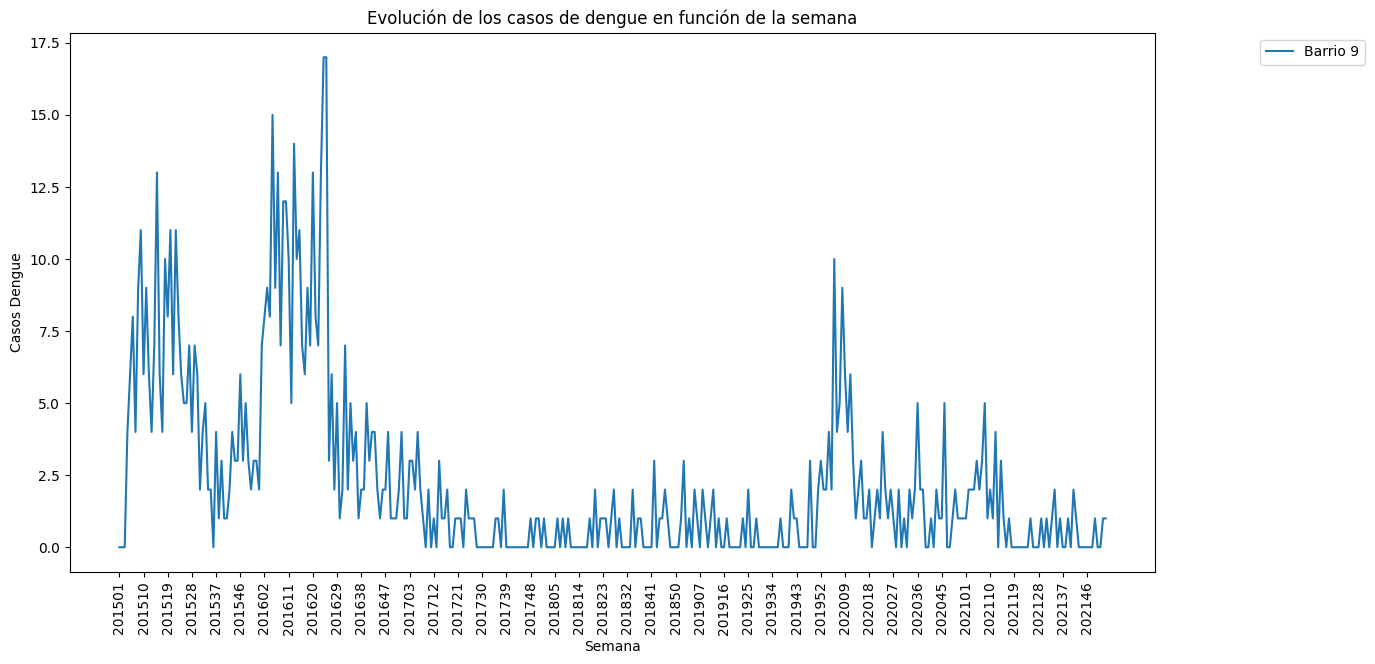

In [48]:
plt.figure(figsize=(14,7))
ax = plt.gca()  # Obtener el eje actual

# Graficar cada barrio en el mismo gráfico
plt.plot(df[df['id_bar'] == barrio_id]['fecha'], df[df['id_bar'] == barrio_id]['dengue'], label=f'Barrio {barrio_id}')

plt.xlabel('Semana')
plt.ylabel('Casos Dengue')
plt.title('Evolución de los casos de dengue en función de la semana')
plt.xticks(np.arange(0,368,9), rotation=90)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))  # Ajustar la leyenda para que no se sobreponga
plt.show()

## Parámetros

In [49]:
SEQUENCE_LENGTH = 5
TARGET_COLUMN = 'dengue'
GROUP_COLUMN = 'id_bar'

## División temporal train/val

In [50]:
# Ordenar datos
df = df.sort_values(by=[GROUP_COLUMN, 'anio', 'semana'])
features_cols_ini = df.columns.difference(['anio', 'semana', TARGET_COLUMN, GROUP_COLUMN, 'id', 'fecha'])

In [51]:
features_cols_ini

Index(['ESTRATO', 'area_barrio', 'concentraciones', 'equipesado', 'lluvia_max',
       'lluvia_mean', 'lluvia_min', 'lluvia_var', 'maquina', 'sumideros',
       'temperatura_max', 'temperatura_mean', 'temperatura_min',
       'temperatura_var', 'vivienda'],
      dtype='object')

In [52]:
df.anio.value_counts(1).sort_index().cumsum()

anio
2015    0.144022
2016    0.288043
2017    0.429348
2018    0.570652
2019    0.711957
2020    0.855978
2021    1.000000
Name: proportion, dtype: float64

In [53]:
train_df = df[df.anio <= 2020].copy()
val_df = df[df.anio >= 2021].copy()

# Estandarizar

In [54]:
features_cols = features_cols_ini.copy()
scaler = StandardScaler().fit(train_df[features_cols])
train_df[features_cols] = scaler.transform(train_df[features_cols])
val_df[features_cols] = scaler.transform(val_df[features_cols])

In [55]:
train_df

,id,id_bar,anio,semana,ESTRATO,area_barrio,dengue,concentraciones,vivienda,equipesado,sumideros,maquina,lluvia_mean,lluvia_var,lluvia_max,lluvia_min,temperatura_mean,temperatura_var,temperatura_max,temperatura_min,fecha
9,0_2015_01,0,2015,1,0.0,1.956409,0.0,-0.213619,-0.191787,-0.252060,-0.58866,-0.284573,-0.851947,-0.609593,-1.103418,0.0,0.031715,0.102178,-0.909305,0.006634,201501
19,0_2015_02,0,2015,2,0.0,1.956409,3.0,-0.213619,-0.191787,-0.252060,-0.58866,-0.284573,-0.696007,-0.517476,-0.239272,0.0,0.069889,-0.597052,-0.878969,-0.854016,201502
29,0_2015_03,0,2015,3,0.0,1.956409,9.0,-0.213619,-0.191787,-0.252060,-0.58866,-0.284573,1.521162,1.844791,1.941309,0.0,-0.852377,0.051358,-0.514937,-1.132462,201503
39,0_2015_04,0,2015,4,0.0,1.956409,5.0,-0.213619,-0.191787,-0.252060,-0.58866,-0.284573,-0.112871,-0.309490,-0.013394,0.0,-1.619721,-1.212388,-1.698041,-1.132462,201504
49,0_2015_05,0,2015,5,0.0,1.956409,5.0,-0.213619,-0.191787,-0.252060,1.13358,-0.284573,-0.677286,-0.578803,-0.775976,0.0,-0.550665,-1.029579,-1.091321,-0.145245,201505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3104,9_2020_49,9,2020,49,0.0,-1.433650,1.0,-0.213619,-0.191787,-0.252060,-0.58866,-0.284573,-0.244578,-0.465497,-0.485942,0.0,-0.676754,-1.196244,-1.356761,-0.268648,202049
3114,9_2020_50,9,2020,50,0.0,-1.433650,2.0,-0.213619,-0.191787,-0.252060,-0.01458,-0.284573,-0.337145,-0.354887,-0.132820,0.0,-0.822238,-0.231416,-1.250585,-0.088291,202050
3124,9_2020_51,9,2020,51,0.0,-1.433650,1.0,-0.213619,-0.191787,-0.252060,-0.58866,1.327664,-0.725413,-0.584582,-0.773665,0.0,-0.512646,-0.745166,-1.151993,0.395825,202051
3134,9_2020_52,9,2020,52,0.0,-1.433650,1.0,-0.213619,0.088812,3.155615,-0.01458,-0.284573,0.372659,0.077798,0.334574,0.0,-1.608459,-0.946357,-0.810713,-0.648346,202052


## Estructura de los datos

In [56]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import clip_grad_norm_
import optuna
from optuna.exceptions import TrialPruned

# -------------------------------------------------------------------
# 1) Carga de datos y cálculo de estadísticas por barrio
# -------------------------------------------------------------------
# Nota: aquí usarías pd.read_parquet(...) si tienes pyarrow/fastparquet instalado.
train_df = pd.read_parquet("../../Datos/df_train.parquet")
val_df  = pd.read_parquet("../../Datos/df_test.parquet")

# Para este ejemplo asumimos que df_train está cargado:
#   - 'id_bar' identifica cada barrio
#   - 'dengue' es el número de casos
#   - hay columnas de covariables en features_cols

# 0) Definición de features_cols
# Asume que `train_df` ya está cargado como pandas DataFrame

# Columnas a excluir: 
#   - 'id' es el identificador de fila
#   - 'id_bar' identifica el barrio (ya lo agrupamos por separado)
#   - 'dengue' es la variable a predecir
exclude = ['id', 'id_bar', 'dengue']

# Todas las demás columnas serán variables predictoras
features_cols = [c for c in train_df.columns if c not in exclude]

print("Usando estas columnas como features:", features_cols)


Usando estas columnas como features: ['anio', 'semana', 'ESTRATO', 'area_barrio', 'concentraciones', 'vivienda', 'equipesado', 'sumideros', 'maquina', 'lluvia_mean', 'lluvia_var', 'lluvia_max', 'lluvia_min', 'temperatura_mean', 'temperatura_var', 'temperatura_max', 'temperatura_min']


In [58]:
# --- 1.1) Calculamos media y varianza de casos por barrio ---
stats = (
    train_df
    .groupby("id_bar")["dengue"]
    .agg(["mean","var"])
    .rename(columns={"mean":"dengue_mean","var":"dengue_var"})
    .reset_index()
)

# --- 1.2) Agrupamos barrios en dos clusters según comportamiento ---
# (Puedes usar k-means, o un umbral manual sobre varianza)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
stats["cluster"] = kmeans.fit_predict(stats[["dengue_mean","dengue_var"]])

# --- 1.3) Definimos un mapping cluster → sequence_length ---
# Decisión: barrios con mayor varianza (cluster==0) usan ventanas más largas
cluster_seq_len = {
    0: 16,   # cluster de alta variabilidad → SEQUENCE_LENGTH largo
    1: 8     # cluster de baja variabilidad → SEQUENCE_LENGTH corto
}

# Creamos un dict id_bar → sequence_length
bar_seq_len = stats.set_index("id_bar")["cluster"].map(cluster_seq_len).to_dict()

In [59]:
# -------------------------------------------------------------------
# 2) Dataset que usa sequence_length dinámico por barrio
# -------------------------------------------------------------------
class DengueDataset(Dataset):
    def __init__(self, df, bar_seq_len_map, is_train=True):
        """
        df: DataFrame completo (train o val)
        bar_seq_len_map: dict {id_bar: sequence_length}
        is_train: si True devuelve (x,y), si False devuelve (x,id)
        """
        self.is_train = is_train
        self.data = []

        # imputar posibles NaN
        df = df.fillna(0.0)

        # agrupamos
        for bar_id, group in df.groupby("id_bar"):
            seq_len = bar_seq_len_map.get(bar_id, 12)  # default=12
            group = group.sort_values(["anio","semana"]).reset_index(drop=True)

            if len(group) <= seq_len:
                continue  # no hay suficiente historia

            # extraer todas las ventanas para este barrio
            for i in range(len(group) - seq_len):
                x_np = (
                    group.loc[i : i + seq_len - 1, features_cols]
                         .to_numpy()
                         .astype(np.float32)
                )
                if is_train:
                    y_val = float(group.loc[i + seq_len, "dengue"])
                    self.data.append((bar_id, x_np, y_val))
                else:
                    row_id = group.loc[i + seq_len, "id"]
                    self.data.append((bar_id, x_np, row_id))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        bar_id, x_np, y_or_id = self.data[idx]
        x = torch.from_numpy(x_np)  # (seq_len, n_features)
        if self.is_train:
            y = torch.tensor(y_or_id, dtype=torch.float32)
            return bar_id, x, y
        else:
            return bar_id, x, y_or_id


In [60]:
# -------------------------------------------------------------------
# 3) DataLoaders (train/val)
# -------------------------------------------------------------------

# Supón que ya tienes split train_df / val_df
train_loader = DataLoader(
    DengueDataset(train_df, bar_seq_len, is_train=True),
    batch_size=32, shuffle=True,  drop_last=True
)
val_loader   = DataLoader(
    DengueDataset(val_df,   bar_seq_len, is_train=False),
    batch_size=32, shuffle=False, drop_last=False
)

In [61]:
# -------------------------------------------------------------------
# 4) Definición de la LSTM “robusta”
# -------------------------------------------------------------------
class RobustLSTMNet(nn.Module):
    def __init__(self,
                 input_size:int,
                 hidden_size:int,
                 num_layers:int=2,
                 bidirectional:bool=True,
                 dropout:float=0.2):
        super().__init__()
        self.hidden_size   = hidden_size
        self.num_layers    = num_layers
        self.bidirectional = bidirectional
        self.num_dirs      = 2 if bidirectional else 1

        # LSTM con dropout y bidireccionalidad
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=dropout if num_layers>1 else 0.0,
            bidirectional=bidirectional
        )
        self.norm = nn.LayerNorm(hidden_size*self.num_dirs)
        self.fc   = nn.Linear(hidden_size*self.num_dirs, 1)

        # inicialización Xavier
        for n,p in self.lstm.named_parameters():
            if "weight" in n: nn.init.xavier_uniform_(p)
            elif "bias" in n: nn.init.zeros_(p)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)

    def forward(self, x):
        # x: (batch, seq_len, features)
        batch = x.size(0)
        # h0, c0: (num_layers*num_dirs, batch, hidden_size)
        h0 = torch.zeros(self.num_layers*self.num_dirs, batch,
                         self.hidden_size, device=x.device)
        c0 = torch.zeros_like(h0)

        out, _ = self.lstm(x, (h0, c0))         # (batch, seq_len, hidden*dirs)
        last    = out[:, -1, :]                 # última salida temporal
        last    = self.norm(last)               # normalizamos
        return self.fc(last).squeeze(-1)

In [62]:
# -------------------------------------------------------------------
# 5) Objetivo de Optuna para la LSTM
# -------------------------------------------------------------------
def objective(trial):
    # 5.1) Espacio de búsqueda
    hidden_size   = trial.suggest_int("hidden_size",  32, 256)
    num_layers    = trial.suggest_int("num_layers",    1,   3)
    bidirectional = trial.suggest_categorical("bidirectional", [False,True])
    dropout       = trial.suggest_float("dropout",   0.0,  0.5)
    lr            = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    weight_decay  = trial.suggest_loguniform("wd", 1e-6, 1e-3)
    clip_value    = trial.suggest_float("clip", 0.5, 5.0)
    max_epochs    = 20

    # 5.2) Instanciamos el modelo
    model = RobustLSTMNet(
        input_size=len(features_cols),
        hidden_size=hidden_size,
        num_layers=num_layers,
        bidirectional=bidirectional,
        dropout=dropout
    ).to(DEVICE)

    optimizer = optim.Adam(
        model.parameters(),
        lr=lr,
        weight_decay=weight_decay
    )
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=5
    )
    criterion = nn.MSELoss()

    # 5.3) Entrenamiento y validación con pruning
    for epoch in range(max_epochs):
        # (a) --- train ---
        model.train()
        train_loss = 0.0
        for _, xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            raw = criterion(model(xb), yb)
            # evitamos NaN sustituyéndolos por un valor grande
            loss = torch.nan_to_num(raw, nan=1e6, posinf=1e6, neginf=1e6)
            loss.backward()
            clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        # (b) --- val ---
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for _, xb, yb in val_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                raw  = criterion(model(xb), yb)
                vloss = torch.nan_to_num(raw, nan=1e6, posinf=1e6, neginf=1e6)
                val_loss += vloss.item()
        val_loss /= len(val_loader)

        # (c) reporte y pruning
        print(f"Epoch {epoch+1:02d}/{max_epochs} – Train Loss: {train_loss:.4f} – Val Loss: {val_loss:.4f}")
        scheduler.step(val_loss)
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise TrialPruned()

    return val_loss

In [ ]:

# -------------------------------------------------------------------
# 6) Lanzamos la búsqueda
# -------------------------------------------------------------------
study = optuna.create_study(
    direction="minimize",
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
)
study.optimize(objective, n_trials=50, timeout=600)

print("✅ Best params:", study.best_params)


# Entrenamiento

In [ ]:
# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros:", study.best_params)
best_hidden_size = study.best_params['hidden_size']
best_num_layers = study.best_params['num_layers']
best_dropout = study.best_params['dropout']
best_bidirectional = study.best_params['bidirectional']
best_learning_rate = study.best_params['lr']
best_weight_decay = study.best_params['wd']
best_clip_value = study.best_params['clip']

# Entrenar el modelo final con los mejores hiperparámetros usando RobustLSTMNet
model = RobustLSTMNet(
    input_size=len(features_cols),
    hidden_size=best_hidden_size,
    num_layers=best_num_layers,
    dropout=best_dropout,
    bidirectional=best_bidirectional
).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=best_learning_rate, weight_decay=best_weight_decay)
criterion = nn.MSELoss()

for epoch in range(50):
    model.train()
    train_loss = 0
    for _, x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
        optimizer.zero_grad()
        preds = model(x_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), best_clip_value)
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for _, x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
            preds = model(x_batch)
            loss = criterion(preds, y_batch)
            val_loss += loss.item()

    print(f'Epoch {epoch+1}/50 | Train MSE: {train_loss/len(train_loader):.4f} | Val MSE: {val_loss/len(val_loader):.4f}')


In [ ]:
# Guardar el mejor modelo encontrado por Optuna
torch.save(model.state_dict(), 'best_LSTM.pth')

# Submission

In [ ]:
# Cargar datos nuevos y preparar submission
features_cols = features_cols_ini.copy()
df_test = pd.read_parquet('../../Datos/df_test.parquet')
df_test = df_test.sort_values(by=[GROUP_COLUMN, 'anio', 'semana'])
df_test[features_cols] = scaler.transform(df_test[features_cols])

In [ ]:
# Agregar últimas SEQUENCE_LENGTH filas del entrenamiento a cada grupo de test
historical_sequences = df.groupby(GROUP_COLUMN).tail(SEQUENCE_LENGTH)
df_test_extended = pd.concat([historical_sequences, df_test], ignore_index=True)
df_test_extended = df_test_extended.sort_values(by=[GROUP_COLUMN, 'anio', 'semana']).reset_index(drop=True)

In [ ]:
df_test_extended

In [ ]:
# Crear loader para predicción
test_loader = DataLoader(DengueDataset(df_test_extended, SEQUENCE_LENGTH, is_train=False), batch_size=32, shuffle=False)

In [ ]:
# Crear loader para predicción
#test_loader = DataLoader(DengueDataset(df_test_extended, SEQUENCE_LENGTH), batch_size=64, shuffle=False)

In [ ]:
# Generar predicciones
model.eval()
predictions = []
ids = []

with torch.no_grad():
    for x_batch, id_batch in test_loader:
        x_batch = x_batch.to(device)
        preds = model(x_batch).cpu().numpy()
        predictions.extend(preds)
        ids.extend(id_batch)


In [ ]:
len(ids)

In [ ]:
# Preparar submission con todos los registros
df_submission = pd.DataFrame({'id': ids, 'dengue': predictions})

# Exportar a CSV
df_submission.to_csv('submission_LSTM.csv', index=False)
print(f'Submission guardado en submission.csv, con {len(df_submission)} predicciones.')

In [ ]:
df_submission